In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import mpl
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn import svm 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
np.set_printoptions(threshold=np.inf)

In [2]:
df_demand_train = pd.read_csv('./demand_train.csv',parse_dates = ['date'])
df_order_train  = pd.read_csv('./order_train.csv')
df_demand_test = pd.read_csv('./demand_test.csv',parse_dates=['date'])
df_order_test  = pd.read_csv('./order_test.csv')
df_order_train['type'] = df_order_train['type'].map({'A1':1,'A2':2,'A3':3})
df_order_test['type'] = df_order_test['type'].map({'A1':1,'A2':2,'A3':3})

# Transform

In [3]:
df_demand_train['year'] = df_demand_train['date'].apply(lambda x:x.year)
df_demand_train['month'] = df_demand_train['date'].apply(lambda x:x.month)
df_demand_train['day'] = df_demand_train['date'].apply(lambda x:x.day)

df_demand_test['year'] = df_demand_test['date'].apply(lambda x:x.year)
df_demand_test['month'] = df_demand_test['date'].apply(lambda x:x.month)
df_demand_test['day'] = df_demand_test['date'].apply(lambda x:x.day)

In [4]:
promt_month=df_demand_train.groupby(['product_id','year','month'])['is_sale_day'].sum()
df_order_train['promts'] = promt_month.values
promt_month=df_demand_test.groupby(['product_id','year','month'])['is_sale_day'].sum()
df_order_test['promts'] = promt_month.values
# data.head(40)

In [5]:
sale_month=df_demand_train.groupby(['product_id','year','month'])['label'].sum()
df_order_train['label'] = sale_month.values
df_order_test['label'] = 0
# data.head(40)

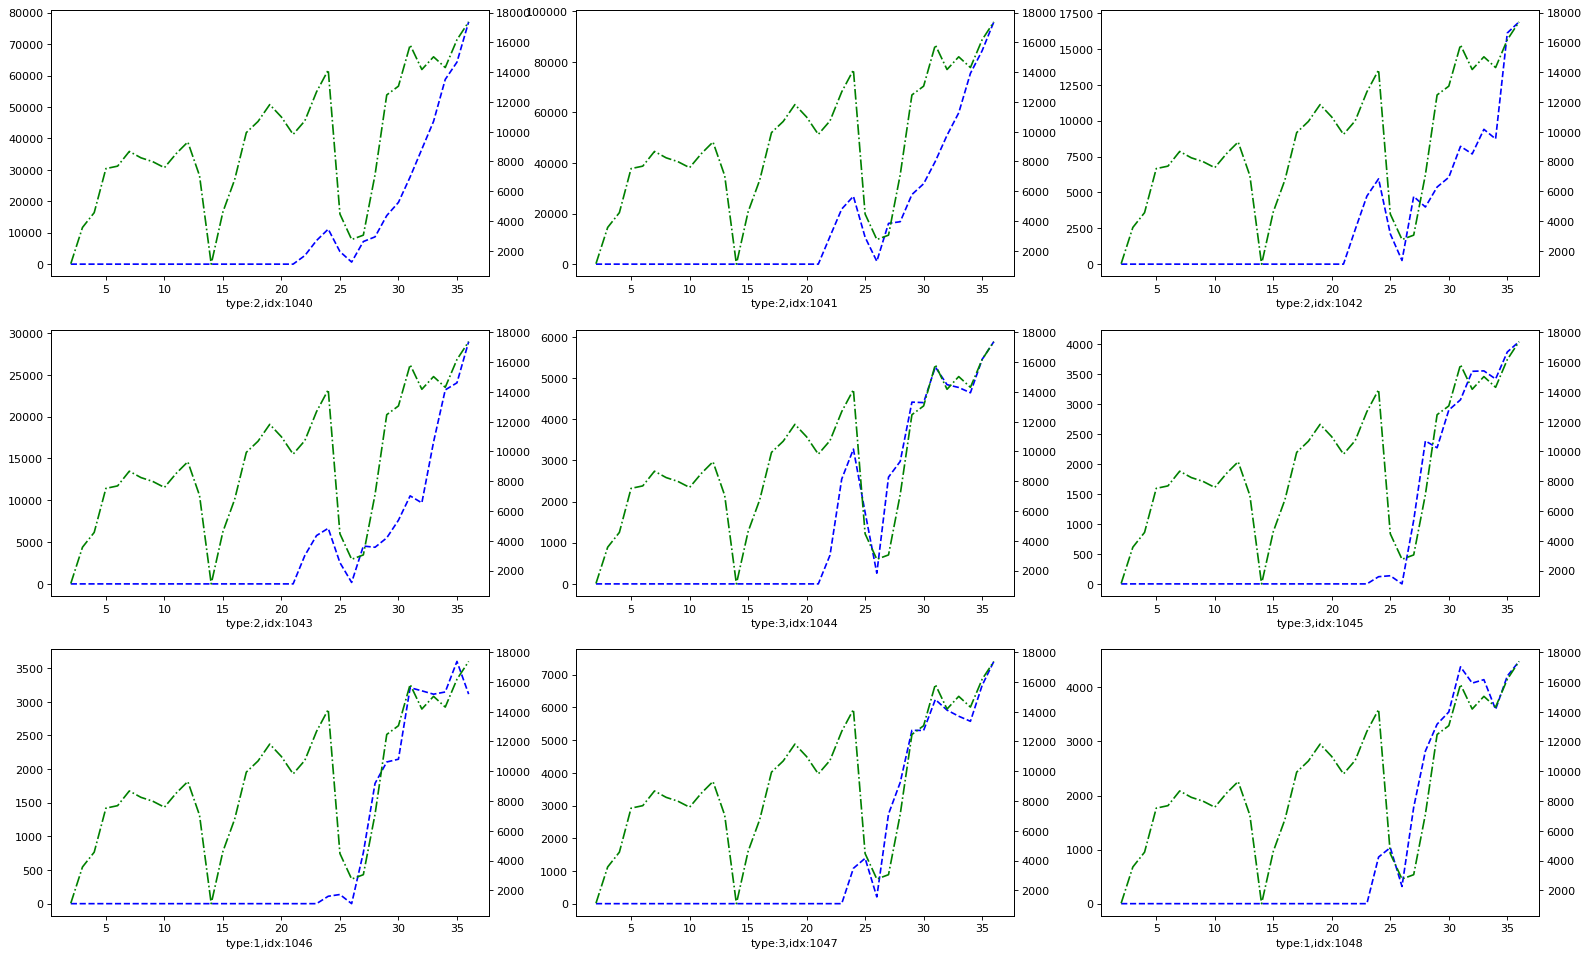

In [6]:
# 绘制前几类的销售量走势

fig = plt.figure(figsize=(24,15),dpi=80)

for i in range(9):
    ax = fig.add_subplot(331+i)
    ax2 = ax.twinx()
    # ax.set_title('#catogory 2')
    data = df_order_train[(df_order_train.product_id==(1070+i))]
    y1 = data.label.values
    y2 = data.order.values
    # y3 = data.promts.values * 200
    ty = data.type.values[0]
    x = (data.year.values - 2018) * 12 + data.month.values
    ax.plot(x,y1,label='sales',color='blue',linestyle='--')
    ax2.plot(x,y2,label='order',color='green',linestyle='-.')
    # ax.plot(x,y3,label='train',color='black',linestyle='-.')
    ax.set_xlabel('type:{},idx:{}'.format(ty,1040+i))
plt.show()

# make features

In [7]:
df_order_train_o = df_order_train.copy()
df_order_test_o = df_order_test.copy()

In [8]:
df_order_train_copy = df_order_train.copy()
df_order_test_copy = df_order_test.copy()

df_order_train['product_id']=df_order_train['product_id'].apply(lambda x:int(str(x)[1:]))
df_order_train['year']=df_order_train['year'].apply(lambda x:x-2018)
df_order_train['month_from_begin']=(df_order_train['year'].values)*12 + df_order_train['month']
df_order_train['is_month2']=(df_order_train['month']==2).apply(lambda x:(-1 if x else 1))   
df_order_train['masked_order']=(df_order_train['order'].values * ((df_order_train['label'] != 0) | df_order_train['month'].isin([10,11,12,1,2,3])).apply(lambda x:(1.0 if x else 0.2)))
df_order_train['masked_order'] = df_order_train['masked_order'].astype(np.float64)
df_order_train['masked_promts']=(df_order_train['promts'].values * ((df_order_train['label'] != 0) | df_order_train['month'].isin([10,11,12,1,2,3])).apply(lambda x:(1.0 if x else 0.2)))
df_order_train['masked_promts'] = df_order_train['masked_promts'].astype(np.float64)
df_order_train['cumsum_sales'] = np.log(df_order_train.groupby('product_id')['label'].cumsum()+1)

df_order_test['product_id']=df_order_test['product_id'].apply(lambda x:int(str(x)[1:]))
df_order_test['year']=df_order_test['year'].apply(lambda x:x-2018)
df_order_test['month_from_begin']=(df_order_test['year'].values)*12 + df_order_test['month']
df_order_test['is_month2']=(df_order_test['month']==2).apply(lambda x:(-1 if x else 1))   
df_order_test['masked_order']=df_order_test['order'].values
df_order_test['masked_promts']=df_order_test['promts'].values
df_order_test['cumsum_sales'] = df_order_train[(df_order_train['year']==3) & (df_order_train.month.isin([10,11,12]))]['cumsum_sales']

In [9]:
df_order_train['date'] = pd.to_datetime([
    '{}-{:02d}-01'.format(
    2018+df_order_train.year[i],df_order_train.month[i]
    ) for i in range(len(df_order_train))
])
df_order_test['date'] = pd.to_datetime([
    '{}-{:02d}-01'.format(
    2018+df_order_test.year[i],df_order_test.month[i]
    ) for i in range(len(df_order_test))
])


In [10]:
df_data = pd.concat((df_order_train,df_order_test),axis=0)
for i in ['3','6','9']:
    data_before = df_data.groupby('product_id')[['label','promts']].shift(int(i)).fillna(0.)
    df_data[['before{}_label'.format(i),'before{}_promts'.format(i)]] = data_before
# 统计值
df_data['before_mean_label'] = (df_data.before3_label.values + df_data.before6_label.values + df_data.before9_label.values)/3
df_data['before_mean_promts'] = (df_data.before3_promts.values + df_data.before6_promts.values + df_data.before9_promts.values)/3
df_data['before_dif1_label'] = (df_data.before3_label.values - df_data.before6_label.values)
df_data['before_dif2_label'] = (df_data.before6_label.values - df_data.before9_label.values)

In [11]:
added_feat = [
    'before3_label', 'before3_promts', 'before6_label', 'before6_promts',
    'before9_label', 'before9_promts', 'before_mean_label',
    'before_mean_promts', 'before_dif1_label', 'before_dif2_label']
df_order_train[added_feat] = df_data[added_feat].iloc[:len(df_order_train),:]
df_order_test[added_feat] = df_data[added_feat].iloc[len(df_order_test):,:]

# Train

In [12]:
df_order_train.columns

Index(['product_id', 'type', 'year', 'month', 'order', 'start_stock',
       'end_stock', 'promts', 'label', 'month_from_begin', 'is_month2',
       'masked_order', 'masked_promts', 'cumsum_sales', 'date',
       'before3_label', 'before3_promts', 'before6_label', 'before6_promts',
       'before9_label', 'before9_promts', 'before_mean_label',
       'before_mean_promts', 'before_dif1_label', 'before_dif2_label'],
      dtype='object')

In [13]:
feat_list = [
    'product_id', 
    'type', 
    'year', 
    'month', 
    'month_from_begin',
    # 'dayofmonth',
    'masked_order',
    'masked_promts', 
    # 'cumsum_sales',
    'start_stock',
    'end_stock',  
    'is_month2',
    'before3_label', 
    'before3_promts', 
    'before6_label', 
    'before6_promts',
    'before9_label', 
    'before9_promts', 
    'before_mean_label',
    'before_mean_promts', 
    'before_dif1_label', 
    'before_dif2_label'
    # 'label', 
]

In [14]:
df_train_X = df_order_train[(df_order_train.year.isin([1,2]))][feat_list]
df_train_y = df_order_train[(df_order_train.year.isin([1,2]))]['label']
df_test_X  = df_order_test[feat_list]

In [15]:
df_train_X.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 11 to 7287
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          5000 non-null   int64  
 1   type                5000 non-null   int64  
 2   year                5000 non-null   int64  
 3   month               5000 non-null   int64  
 4   month_from_begin    5000 non-null   int64  
 5   masked_order        5000 non-null   float64
 6   masked_promts       5000 non-null   float64
 7   start_stock         4956 non-null   float64
 8   end_stock           4956 non-null   float64
 9   is_month2           5000 non-null   int64  
 10  before3_label       5000 non-null   float64
 11  before3_promts      5000 non-null   float64
 12  before6_label       5000 non-null   float64
 13  before6_promts      5000 non-null   float64
 14  before9_label       5000 non-null   float64
 15  before9_promts      5000 non-null   float64
 16  befor

In [16]:
print(len(df_train_X),len(df_test_X))

5000 627


In [17]:
K = 8
kf = KFold(8,shuffle=True,random_state=520,)

#poisson regression

lgb_params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'bagging_fraction': 0.8,
    'bagging_freq':1,
    'num_leaves': 80,
    'colsample_bytree': 0.6,
    'min_data': 200,
    'min_hessian': 1,   
    'verbose': -1
}

In [18]:
def evalerror(pred,df):
    label = df.get_label().copy()
    score = mean_squared_error(label,pred)*0.5
    return ('0.5 mse',np.sqrt(score),False)


In [19]:
train_preds_lgb = np.zeros(df_train_X.shape[0])
test_preds_lgb = np.zeros((df_test_X.shape[0],K))

for i,(train_idx,val_idx) in enumerate(kf.split(df_train_X)):
    print('\n 第{}次训练...'.format(i))
    train_feat1 = df_train_X.iloc[train_idx]
    train_feat2 = df_train_X.iloc[val_idx]
    train_target1 = df_train_y.iloc[train_idx]
    train_target2 = df_train_y.iloc[val_idx]

    print('lightgbm')
    lgb_train1 = lgb.Dataset(train_feat1.values,train_target1.values)
    lgb_train2 = lgb.Dataset(train_feat2.values,train_target2.values)

    gbm = lgb.train(
        lgb_params,
        lgb_train1,
        num_boost_round=20000,
        valid_sets=lgb_train2,
        verbose_eval=500,
        feval=evalerror,
        early_stopping_rounds=200    
    )
    train_preds_lgb[val_idx] += gbm.predict(train_feat2)
    test_preds_lgb[:,i] = gbm.predict(df_test_X)
    print('\n')


 第0次训练...
lightgbm
Training until validation scores don't improve for 200 rounds
[500]	valid_0's poisson: -21548.8	valid_0's 0.5 mse: 2575.72
[1000]	valid_0's poisson: -21753.3	valid_0's 0.5 mse: 2124.98
[1500]	valid_0's poisson: -21806.4	valid_0's 0.5 mse: 1958.88
[2000]	valid_0's poisson: -21825.8	valid_0's 0.5 mse: 1873.63
[2500]	valid_0's poisson: -21834.2	valid_0's 0.5 mse: 1858.85
Early stopping, best iteration is:
[2440]	valid_0's poisson: -21834	valid_0's 0.5 mse: 1853.47



 第1次训练...
lightgbm
Training until validation scores don't improve for 200 rounds
[500]	valid_0's poisson: -18269.9	valid_0's 0.5 mse: 1801.52
[1000]	valid_0's poisson: -18439.2	valid_0's 0.5 mse: 1654.45
[1500]	valid_0's poisson: -18501.2	valid_0's 0.5 mse: 1484.26
[2000]	valid_0's poisson: -18522.6	valid_0's 0.5 mse: 1397.19
[2500]	valid_0's poisson: -18530.2	valid_0's 0.5 mse: 1369.24
[3000]	valid_0's poisson: -18534.1	valid_0's 0.5 mse: 1358.33
Early stopping, best iteration is:
[3014]	valid_0's poisson

In [20]:
df_train = df_order_train[df_order_train.year.isin([1,2])].copy()
df_train['preds']=train_preds_lgb
df_train.drop(df_train[(df_train['product_id']==145)].index,inplace=True)
df_Acc = df_train[['year','month','product_id','label','preds']]

In [21]:
gt = df_train['label'].values
preds = df_Acc['preds'].values
acc = (1-np.abs(gt-preds)/(gt+1e-6))
df_train['acc'] = acc
df_train.head()

,product_id,type,year,month,order,start_stock,end_stock,promts,label,month_from_begin,is_month2,masked_order,masked_promts,cumsum_sales,date,before3_label,before3_promts,before6_label,before6_promts,before9_label,before9_promts,before_mean_label,before_mean_promts,before_dif1_label,before_dif2_label,preds,acc
11,1,1,1,1,7049.0,110.0,270.0,0,3469.0,13,1,7049.0,0.0,10.851664,2019-01-01,4509.0,0.0,4954.0,0.0,4186.0,0.0,4549.666667,0.000000,-445.0,768.0,3282.931864,0.946363
12,1,1,1,2,1101.0,270.0,234.0,7,986.0,14,-1,1101.0,7.0,10.870585,2019-02-01,4840.0,0.0,5038.0,0.0,5412.0,0.0,5096.666667,0.000000,-198.0,-374.0,1100.999291,0.883368
13,1,1,1,3,4611.0,234.0,151.0,31,3583.0,15,1,4611.0,31.0,10.936476,2019-03-01,5113.0,0.0,4726.0,0.0,5665.0,0.0,5168.000000,0.000000,387.0,-939.0,3466.882030,0.967592
14,1,1,1,4,6769.0,151.0,96.0,30,4438.0,16,1,6769.0,30.0,11.012496,2019-04-01,3469.0,0.0,4509.0,0.0,4954.0,0.0,4310.666667,0.000000,-1040.0,-445.0,4356.520375,0.981640
15,1,1,1,5,9941.0,99.0,66.0,31,5932.0,17,1,9941.0,31.0,11.105844,2019-05-01,986.0,7.0,4840.0,0.0,5038.0,0.0,3621.333333,2.333333,-3854.0,-198.0,4325.239344,0.729137


In [22]:
gt = df_train.groupby(['year','month','product_id'])[['label']].mean().values
acc = df_train.groupby(['year','month','product_id'])[['acc']].mean().values

In [23]:
gt.shape,acc.shape
NUM_CLASS = 208
gt = gt.reshape((-1,NUM_CLASS))
acc = acc.reshape((-1,NUM_CLASS))
gt.shape,acc.shape
gt = gt / (gt.sum(axis=1,keepdims=True) + 1e-6)
acc = (acc * gt).sum(axis=1)

In [24]:
year,month = 2018, 2
mean_acc = []
for i in range(acc.shape[0]):
    print('{:02d} | {}-{:02d} acc: {:.4f}%'.format(i,year,month,100*acc[i]))
    if month % 12 == 0:
        month = 0
        year += 1
    month +=1
    mean_acc.append(100*acc[i])
print('mean_acc:{:.4f}%'.format(sum(mean_acc)/len(mean_acc)))

# mean_acc:73.4580%
# mean_acc:73.3399%
# mean_acc:75.1823% change min_data
# mean_acc:75.4829%
# mean_acc:70.2288% just use two year's data, have improve in some day
# mean_acc:75.2338% with masked order


00 | 2018-02 acc: 73.1924%
01 | 2018-03 acc: 68.9771%
02 | 2018-04 acc: 76.2266%
03 | 2018-05 acc: 83.6576%
04 | 2018-06 acc: 71.4038%
05 | 2018-07 acc: 79.1657%
06 | 2018-08 acc: 80.2154%
07 | 2018-09 acc: 81.0249%
08 | 2018-10 acc: 86.3797%
09 | 2018-11 acc: 77.9569%
10 | 2018-12 acc: 75.9241%
11 | 2019-01 acc: 79.8053%
12 | 2019-02 acc: 81.7386%
13 | 2019-03 acc: -6.4054%
14 | 2019-04 acc: 78.9211%
15 | 2019-05 acc: 72.6721%
16 | 2019-06 acc: 70.9997%
17 | 2019-07 acc: 73.1150%
18 | 2019-08 acc: 80.2738%
19 | 2019-09 acc: 86.0897%
20 | 2019-10 acc: 85.7274%
21 | 2019-11 acc: 76.4435%
22 | 2019-12 acc: 76.7542%
23 | 2020-01 acc: 79.8128%
mean_acc:74.5863%


In [25]:
# 统计每一个类的正确率 

In [26]:
ans_X  = df_order_test.copy()
ans_X.product_id=ans_X.product_id.apply(lambda x:x+1000)
ans_X.year=ans_X.year.apply(lambda x:2021)
ans_X.label = test_preds_lgb.sum(axis=1)/K

In [27]:
df_ans = ans_X.groupby(['month','product_id'])['month','product_id','label'].mean()
df_ans.head()

month  product_id         label
month product_id                                 
1     1001          1.0      1001.0   3090.453749
      1002          1.0      1002.0  10348.823047
      1003          1.0      1003.0   3004.844777
      1004          1.0      1004.0  10750.887799
      1005          1.0      1005.0   5309.679197

In [28]:
df_ans['month']=df_ans['month'].apply(lambda x:'2021-0{}'.format(int(x)))
df_ans['product_id']=df_ans['product_id'].apply(lambda x:int(x))
df_ans.to_csv('submit_2year_masked_v3.csv',index=False)
df_ans.head()

month  product_id         label
month product_id                                   
1     1001        2021-01        1001   3090.453749
      1002        2021-01        1002  10348.823047
      1003        2021-01        1003   3004.844777
      1004        2021-01        1004  10750.887799
      1005        2021-01        1005   5309.679197

In [29]:
lgb_params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'bagging_fraction': 0.8,
    'bagging_freq':1,
    'num_leaves': 6,
    'colsample_bytree': 0.6,
    'min_data': 4,
    'min_hessian': 1,   
    'verbose': -1
}

feat_list2 = [
    'product_id', 
    'type', 
    'year', 
    'month', 
    'month_from_begin',
    # 'dayofmonth',
    'masked_order',
    # 'masked_promts', 
    'cumsum_sales',
    'order',
    'promts',
    'start_stock',
    'end_stock',  
    'is_month2',
    # 'label', 
]

df_train_X = df_order_train[(df_order_train.year.isin([2]))][feat_list2]
df_train_y = df_order_train[(df_order_train.year.isin([2]))]['label']
df_test_X  = df_order_test[feat_list2]

In [30]:
# 这里使用第三年的数据在单独训练一个模型，考虑order和预测的百分比综合

train_preds_lgb2 = np.zeros(df_train_X.shape[0])
test_preds_lgb2 = np.zeros((df_test_X.shape[0],K))

for i,(train_idx,val_idx) in enumerate(kf.split(df_train_X)):
    print('\n 第{}次训练...'.format(i))
    train_feat1 = df_train_X.iloc[train_idx]
    train_feat2 = df_train_X.iloc[val_idx]
    train_target1 = df_train_y.iloc[train_idx]
    train_target2 = df_train_y.iloc[val_idx]

    print('lightgbm')
    lgb_train1 = lgb.Dataset(train_feat1.values,train_target1.values)
    lgb_train2 = lgb.Dataset(train_feat2.values,train_target2.values)

    gbm = lgb.train(
        lgb_params,
        lgb_train1,
        num_boost_round=10000,
        valid_sets=lgb_train2,
        verbose_eval=500,
        feval=evalerror,
        early_stopping_rounds=100    
    )
    train_preds_lgb2[val_idx] += gbm.predict(train_feat2)
    test_preds_lgb2[:,i] = gbm.predict(df_test_X)
    print('\n')


 第0次训练...
lightgbm
Training until validation scores don't improve for 100 rounds
[500]	valid_0's poisson: -30334.3	valid_0's 0.5 mse: 1512.72
[1000]	valid_0's poisson: -30488.3	valid_0's 0.5 mse: 1386.79
Early stopping, best iteration is:
[1084]	valid_0's poisson: -30495.5	valid_0's 0.5 mse: 1386.03



 第1次训练...
lightgbm
Training until validation scores don't improve for 100 rounds
[500]	valid_0's poisson: -21629.6	valid_0's 0.5 mse: 1410.97
[1000]	valid_0's poisson: -21778.7	valid_0's 0.5 mse: 1349.18
[1500]	valid_0's poisson: -21810.9	valid_0's 0.5 mse: 1257.87
[2000]	valid_0's poisson: -21825.9	valid_0's 0.5 mse: 1187.66
[2500]	valid_0's poisson: -21836.1	valid_0's 0.5 mse: 1134.05
[3000]	valid_0's poisson: -21843.7	valid_0's 0.5 mse: 1094.68
[3500]	valid_0's poisson: -21849.5	valid_0's 0.5 mse: 1067.55
[4000]	valid_0's poisson: -21854.2	valid_0's 0.5 mse: 1046.16
[4500]	valid_0's poisson: -21858	valid_0's 0.5 mse: 1027.59
[5000]	valid_0's poisson: -21861	valid_0's 0.5 mse: 1014.69

In [31]:
df_train = df_train_X = df_order_train[(df_order_train.year.isin([2]))]
df_train['preds'] = train_preds_lgb2
df_train['acc'] = (1-np.abs(df_train.label.values-df_train.preds.values)/(df_train.label.values + 1e-6))
# df_train.drop(df_train[(df_train.product_id==145)].index,inplace=True)

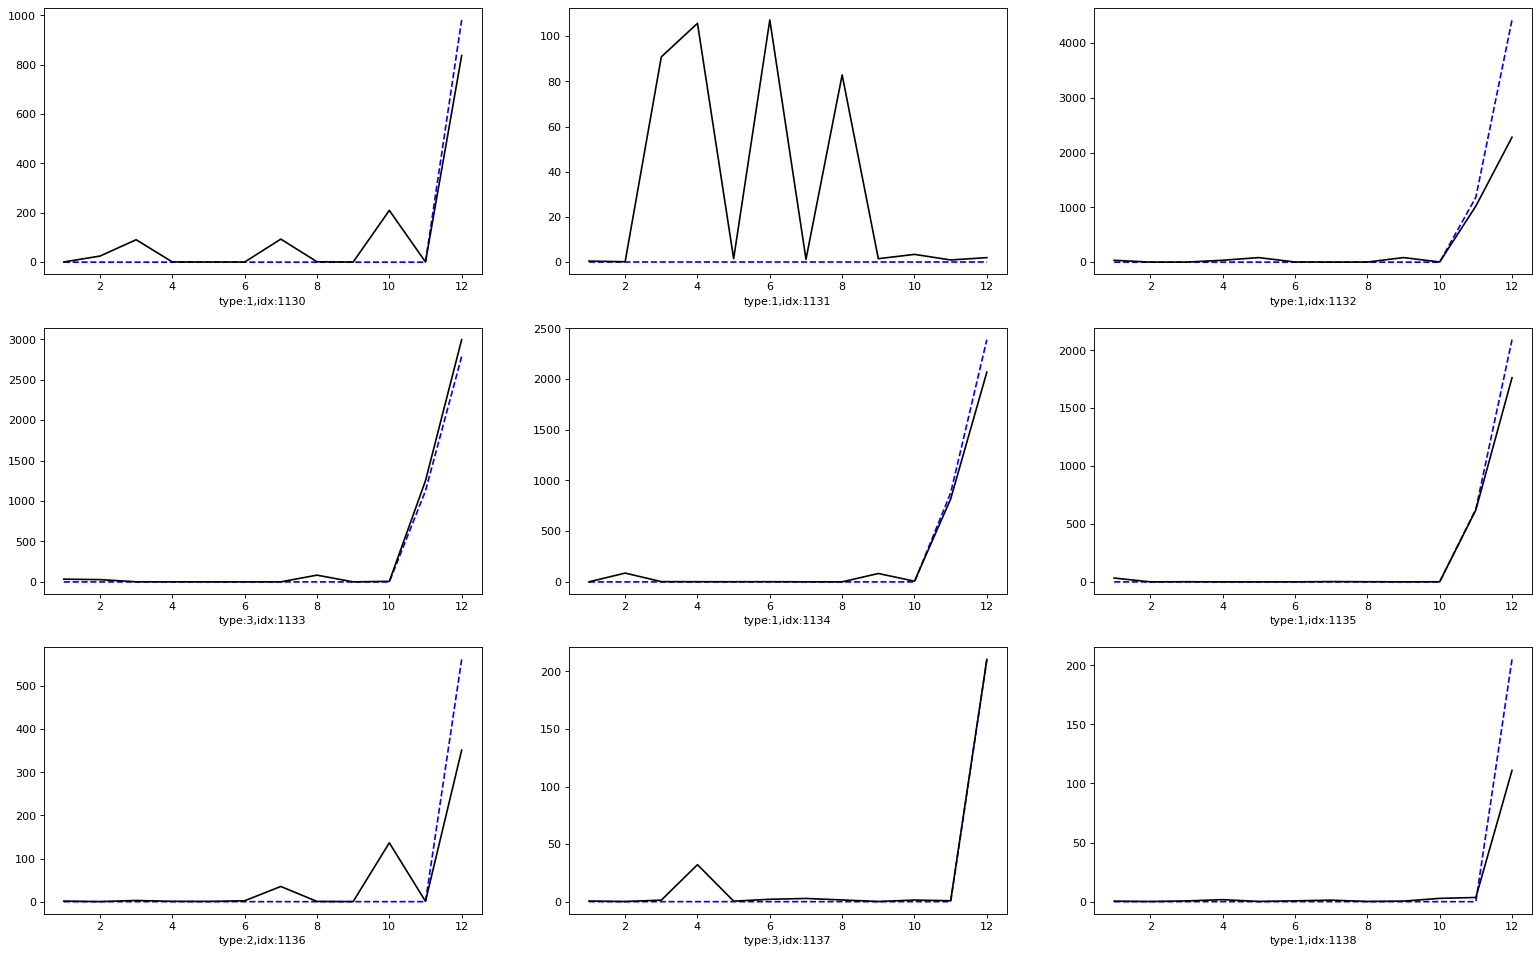

In [32]:
# 绘制前几类的销售量走势

fig = plt.figure(figsize=(24,15),dpi=80)

for i in range(9):
    ax = fig.add_subplot(331+i)
    # ax2 = ax.twinx()
    # ax.set_title('#catogory 2')
    data = df_train[(df_order_train.product_id==(130+i))]
    if data.empty:
        continue
    y1 = data.label.values
    # y2 = data.order.values
    y3 = data.preds.values
    # y3 = data.promts.values * 200
    ty = data.type.values[0]
    x = (data.year.values-2) * 12 + data.month.values
    ax.plot(x,y1,label='sales',color='blue',linestyle='--')
    ax.plot(x,y3,label='order',color='black',linestyle='-')
    # ax2.plot(x,y2,label='order',color='green',linestyle='-.')
    # ax.plot(x,y3,label='train',color='black',linestyle='-.')
    ax.set_xlabel('type:{},idx:{}'.format(ty,1130+i))
plt.show()

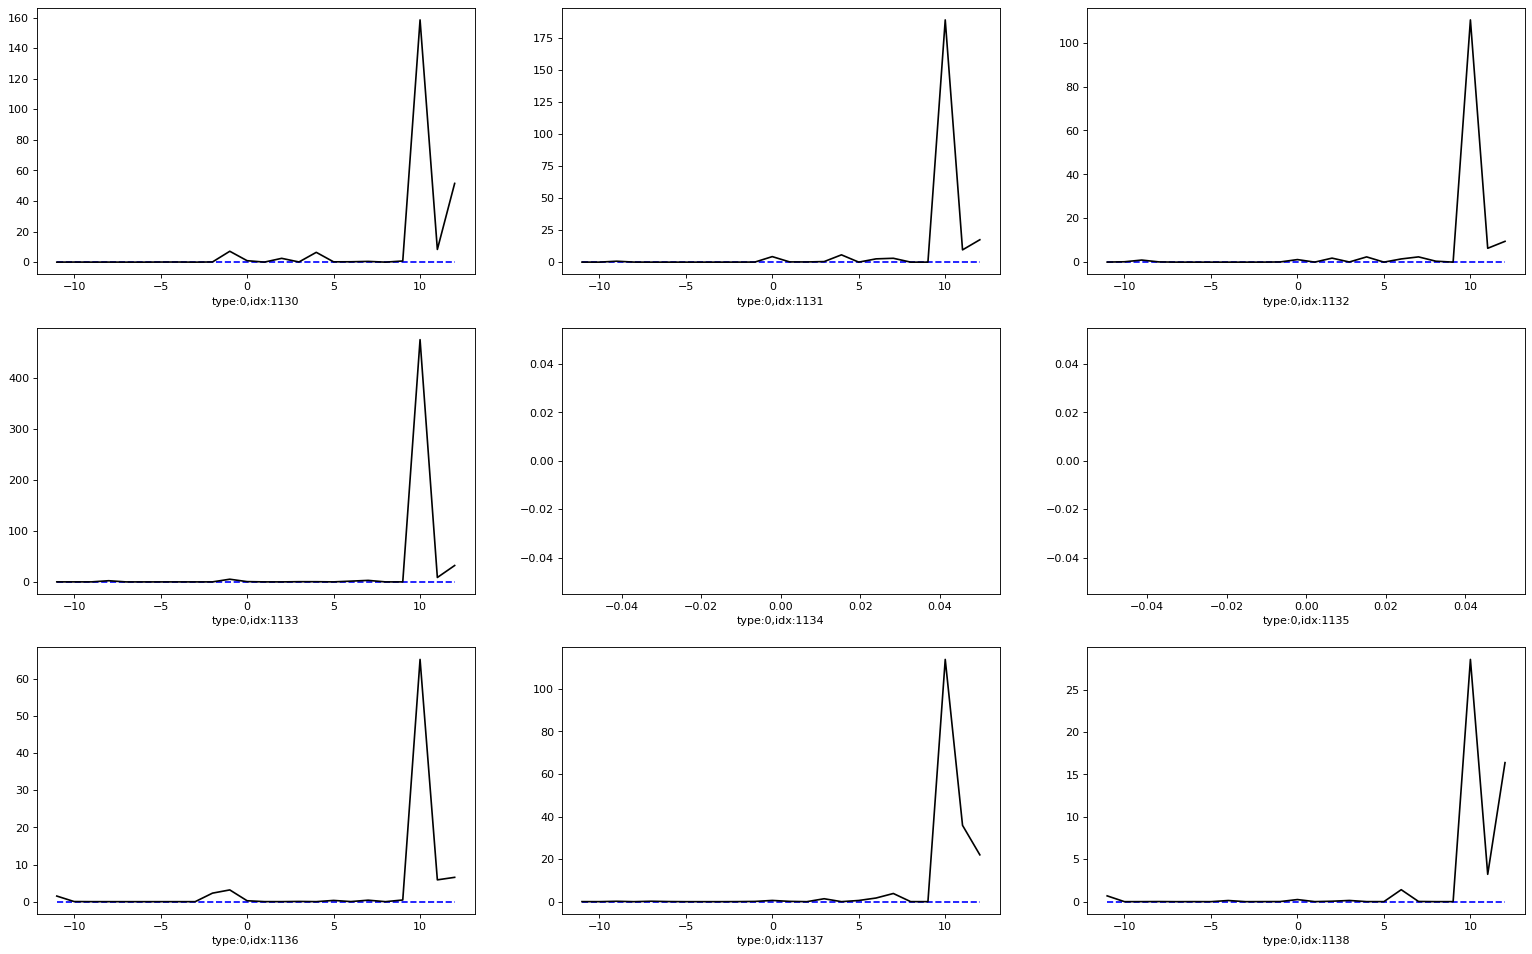

In [33]:
# 绘制前几类的销售量走势

fig = plt.figure(figsize=(24,15),dpi=80)

for i in range(9):
    ax = fig.add_subplot(331+i)
    # ax2 = ax.twinx()
    # ax.set_title('#catogory 2')
    data = df_Acc[(df_Acc.product_id==(140+i))]
    y1 = data.label.values
    # y2 = data.order.values
    y3 = data.preds.values
    # y3 = data.promts.values * 200
    ty = 0
    x = (data.year.values-2) * 12 + data.month.values
    ax.plot(x,y1,label='sales',color='blue',linestyle='--')
    ax.plot(x,y3,label='order',color='black',linestyle='-')
    # ax2.plot(x,y2,label='order',color='green',linestyle='-.')
    # ax.plot(x,y3,label='train',color='black',linestyle='-.')
    ax.set_xlabel('type:{},idx:{}'.format(ty,1130+i))
plt.show()

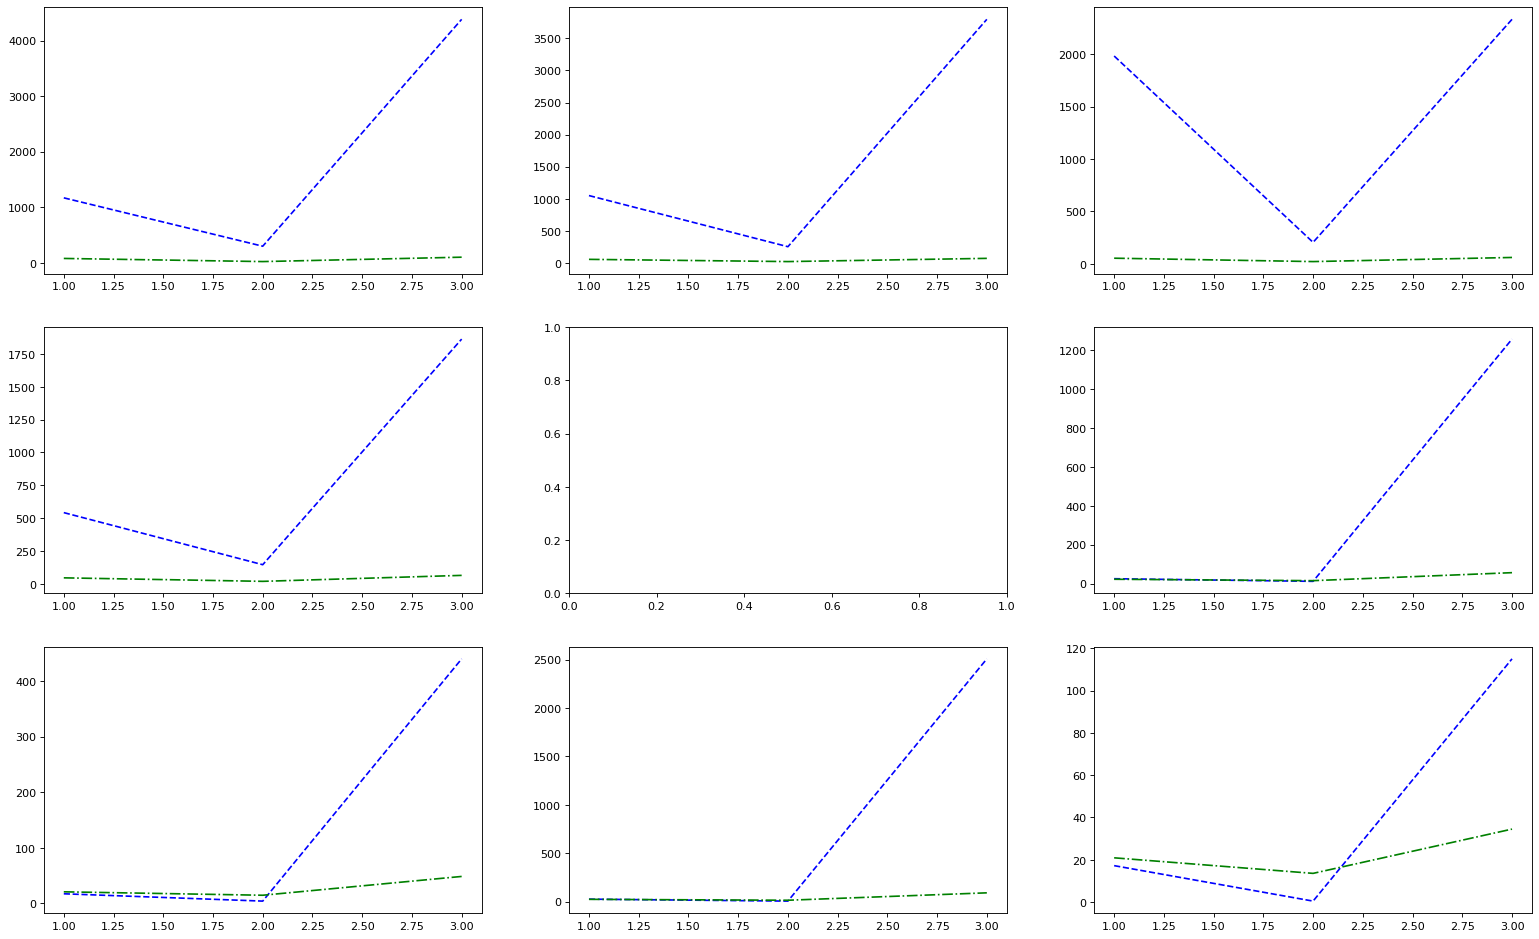

In [34]:
# 两种测试方法，在预测上的差异
ans_X1  = df_order_test.copy()
ans_X1.label = test_preds_lgb.sum(axis=1)/K

ans_X2  = df_order_test.copy()
ans_X2.label = test_preds_lgb2.sum(axis=1)/K
# 绘制前几类的销售量走势

fig = plt.figure(figsize=(24,15),dpi=80)

for i in range(9):
    ax = fig.add_subplot(331+i)
    # ax2 = ax.twinx()
    # ax.set_title('#catogory 2')
    data1 = ans_X1[(ans_X1.product_id==(140+i))]
    data2 = ans_X2[(ans_X2.product_id==(140+i))]
    if data1.empty:
        continue    
    y1 = data1.label.values
    y2 = data2.label.values
    x = [1,2,3]
    ax.plot(x,y1,label='sales',color='blue',linestyle='--')
    ax.plot(x,y2,label='sales',color='green',linestyle='-.')
    # ax.set_xlabel('type:{},idx:{}'.format(ty,1040+i))
plt.show()

In [35]:
index = (df_order_train.groupby('product_id')['cumsum_sales'].max()<2)
index = [i for i in range(len(index)) if index.iloc[i]==True]
print(index)

[116, 130, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]


In [36]:
len(test_preds_lgb),len(test_preds_lgb2),len(ans_X)

(627, 627, 627)

In [43]:
preds = [
    (
        test_preds_lgb[i] * 0.5 + test_preds_lgb2[i] * 0.5
        if int(ans_X.iloc[i]['product_id']) in index
        else test_preds_lgb[i]
    ) for i in range(len(ans_X))
]
preds = np.array(preds)

In [44]:
ans_X  = df_order_test.copy()
ans_X.product_id=ans_X.product_id.apply(lambda x:x+1000)
ans_X.year=ans_X.year.apply(lambda x:2021)
ans_X.label = preds

In [45]:
ans_X.head()

,product_id,type,year,month,order,start_stock,end_stock,promts,label,month_from_begin,is_month2,masked_order,masked_promts,cumsum_sales,date,before3_label,before3_promts,before6_label,before6_promts,before9_label,before9_promts,before_mean_label,before_mean_promts,before_dif1_label,before_dif2_label
0,1001,1,2021,1,15182.0,117.0,165.0,31,3281.055620,37,1,15182.0,31,NaN,2021-01-01,3118.0,31.0,4025.0,31.0,2976.0,30.0,3373.000000,30.666667,-907.0,1049.0
1,1001,1,2021,2,1128.0,165.0,151.0,28,621.646229,38,-1,1128.0,28,NaN,2021-02-01,3364.0,30.0,3492.0,31.0,3701.0,31.0,3519.000000,30.666667,-128.0,-209.0
2,1001,1,2021,3,10756.0,151.0,129.0,31,3345.060977,39,1,10756.0,31,NaN,2021-03-01,3250.0,31.0,3213.0,30.0,3729.0,30.0,3397.333333,30.333333,37.0,-516.0
3,1002,2,2021,1,15182.0,213.0,869.0,0,11477.194428,37,1,15182.0,0,NaN,2021-01-01,9396.0,0.0,11252.0,0.0,6646.0,0.0,9098.000000,0.000000,-1856.0,4606.0
4,1002,2,2021,2,1128.0,869.0,676.0,0,1826.479274,38,-1,1128.0,0,NaN,2021-02-01,10970.0,0.0,10267.0,0.0,8765.0,0.0,10000.666667,0.000000,703.0,1502.0


In [46]:
df_ans = ans_X.groupby(['month','product_id'])['month','product_id','label'].mean()
df_ans.head()

month  product_id         label
month product_id                                 
1     1001          1.0      1001.0   3281.055620
      1002          1.0      1002.0  11477.194428
      1003          1.0      1003.0   3155.800582
      1004          1.0      1004.0  12262.296201
      1005          1.0      1005.0   5428.127414

In [47]:
df_ans['month']=df_ans['month'].apply(lambda x:'2021-0{}'.format(int(x)))
df_ans['product_id']=df_ans['product_id'].apply(lambda x:int(x))
df_ans.to_csv('submit_2year_masked_v6.csv',index=False)
df_ans.head()

month  product_id         label
month product_id                                   
1     1001        2021-01        1001   3281.055620
      1002        2021-01        1002  11477.194428
      1003        2021-01        1003   3155.800582
      1004        2021-01        1004  12262.296201
      1005        2021-01        1005   5428.127414